In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import print_function
import warnings
warnings.filterwarnings('ignore')
from subprocess import check_output

PREPARACIÓN DE DATOS:
Vamos a realizar una clasificación binaria con los dígitos 0 y 1. 
Esta red cambiando los parámetros; input layer, podemos utilizarla para
el problema de Halos.

In [2]:
x_l = np.load('X.npy')
Y_l = np.load('Y.npy')

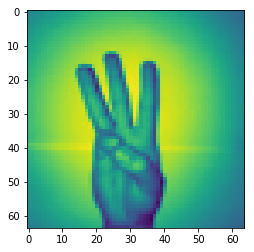

In [3]:
plt.imshow(x_l[800])

(-0.5, 63.5, 63.5, -0.5)

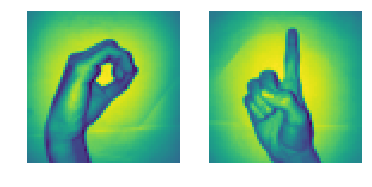

In [4]:
img_size = 64
plt.subplot(1, 2, 1)
plt.imshow(x_l[260].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_l[900].reshape(img_size, img_size))
plt.axis('off')

Los dígitos 0 y 1 van a estar en las matrices con los valores utilizados en la siguiente linea

In [5]:
X=np.concatenate((x_l[204:409],x_l[822:1027]),axis=0)

Vamos a crear nuestro Target

In [6]:
len(X)

410

In [7]:
z=np.zeros(205)
o=np.ones(205)
Y=np.concatenate((z,o),axis=0)

In [8]:
Y.shape

(410,)

Vamos a hacer nuestra partición de nuestros datos de prueba y test. 
El 15% de los datos será de test

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)
number_of_train = X_train.shape[0]
number_of_test = X_test.shape[0]

In [10]:
number_of_train

348

In [11]:
X_train_flatten = X_train.reshape(number_of_train,X_train.shape[1]*X_train.shape[2])
X_test_flatten = X_test .reshape(number_of_test,X_test.shape[1]*X_test.shape[2])
print("X train flatten",X_train_flatten.shape)
print("X test flatten",X_test_flatten.shape)

X train flatten (348, 4096)
X test flatten (62, 4096)


In [12]:
features_train = X_train_flatten
features_test = X_test_flatten
targets_train = Y_train
targets_test = Y_test


In [13]:
features_train.shape

(348, 4096)

In [14]:
targets_train.shape

(348,)

In [15]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.autograd import Variable

In [16]:
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) 
featuresTest = torch.from_numpy(features_test)
targetsTest = torch.from_numpy(targets_test).type(torch.LongTensor) 

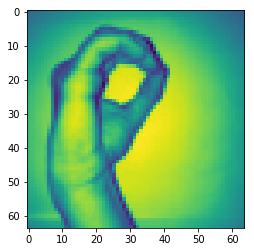

In [17]:
#Batch e iteración
batch_size = 1
n_iters =10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)
#Creamos tensores de test y train
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
test = torch.utils.data.TensorDataset(featuresTest,targetsTest)

# los cargamos para alimentar la red
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test, batch_size = batch_size, shuffle = False)

#Vamos a observar si hicimos bien la conversión
plt.imshow(X[0].reshape(64,64))
plt.show()

In [18]:
#creamos la clase de la red neurnal
class ANNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        super(ANNModel, self).__init__()
        # mandamos las 64*64 neuronas a la siguiente capa de 100
        self.fc1 = nn.Linear(input_dim, hidden_dim1) 
        # Función de activación
        self.relu1 = nn.ReLU()
        
        # mandamos las 100 neuronas a la siguiente capa de 50
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        # función de activación # ensayamos esta aunque podríamos usar la ELU
        self.tanh2 = nn.Tanh()
        
        # Salida 50 neuronas a 2 para clasificación
        self.fc3 = nn.Linear(hidden_dim2, output_dim)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        
       
        out = self.fc2(out)
        out = self.tanh2(out)
        
        out = self.fc3(out)
        return out

# Parámetros de la red
input_dim = 64*64
hidden_dim1 = 50
hidden_dim2=100 
output_dim = 2

# Generamos la red
model = ANNModel(input_dim, hidden_dim1,hidden_dim2, output_dim)

# Función de error, por ensayar entropía cruzada
error = nn.CrossEntropyLoss()

# Stochastic gradient descent
learning_rate = 0.02
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [20]:
#Entrenamiento
count = 0
loss_list = []
iteration_list = []
accuracy_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        train = Variable(images.view(-1, 64*64))
        labels = Variable(labels)
        
        # gradientes a cero
        optimizer.zero_grad()
        
        # Propagación
        outputs = model(train)
        
        # Error
        loss = error(outputs, labels)
        
        # Gradientes
        loss.backward()
        
        # Actualizaciòn
        optimizer.step()
        
        count += 1
        
        if count % 50 == 0:         
            correct = 0
            total = 0
           
            for images, labels in test_loader:
                test = Variable(images.view(-1, 64*64))
                outputs = model(test)
                predicted = torch.max(outputs.data, 1)[1]
                total += len(labels)
                correct += (predicted == labels).sum()
            
            accuracy = 100 * correct / float(total)
            
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                print('Iteracion: {} Error: {}  Efectividad: {} %'.format(count, loss.data[0], accuracy))

Iteracion: 500 Error: 0.142311155796  Efectividad: 91 %
Iteracion: 1000 Error: 2.20510601997  Efectividad: 72 %
Iteracion: 1500 Error: 0.0678391456604  Efectividad: 95 %
Iteracion: 2000 Error: 0.339352369308  Efectividad: 95 %
Iteracion: 2500 Error: 0.00612258911133  Efectividad: 88 %
Iteracion: 3000 Error: 0.00265336036682  Efectividad: 93 %
Iteracion: 3500 Error: 0.00197172164917  Efectividad: 95 %
Iteracion: 4000 Error: 0.135508537292  Efectividad: 87 %
Iteracion: 4500 Error: 0.00229120254517  Efectividad: 93 %
Iteracion: 5000 Error: 0.0012001991272  Efectividad: 93 %
Iteracion: 5500 Error: 0.00851106643677  Efectividad: 91 %
Iteracion: 6000 Error: 0.000280380249023  Efectividad: 95 %
Iteracion: 6500 Error: 0.00371670722961  Efectividad: 93 %
Iteracion: 7000 Error: 3.95774841309e-05  Efectividad: 93 %
Iteracion: 7500 Error: 0.0231212377548  Efectividad: 93 %
Iteracion: 8000 Error: 0.0214593410492  Efectividad: 93 %
Iteracion: 8500 Error: 0.0185933113098  Efectividad: 95 %
Iteracion:

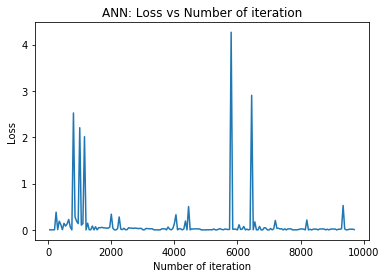

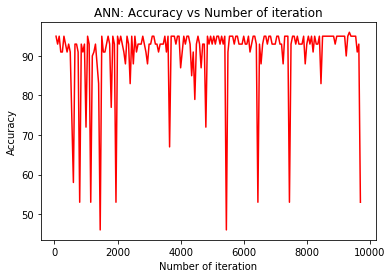

In [28]:

plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()
